# Вспомогательный код

In [ ]:
def exponential_smoothing(scalars, weight):
    last = scalars[0]
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


class HistoryPlotter:
    def __init__(self):
        # dict for safe learning history
        self._history_dict = {}

    def add(self, history):
        """
        Save learning history.
        history: dict with keys: model_name, epoсhs, loss_on_train, loss_on_test
        """
        self._history_dict[history["model_name"]] = history
        self.color_list = list(mcolors.TABLEAU_COLORS.keys())

    def plot(self, models, show_smooth=True, smooth_val=0.90):
        """
        Plot informatiom from self._history_dict.
        models: list of model_name (len <= 5, or extend color_list)
        """
        fig, ax = plt.subplots(3, 1, figsize=(10, 10))
        for model_num, model_name in enumerate(models):
            history = self._history_dict[model_name]
            for idx, (key, title) in enumerate(
                zip(["loss_on_train", "loss_on_test"], ["train loss", "test loss"])
            ):
                epoch_len = len(history[key]) // history["epoсhs"]
                loss_len = len(history[key])
                ticks_positions = np.arange(history["epoсhs"] + 1)

                if show_smooth:
                    x = np.arange(len(history[key])) / epoch_len
                    # Plot train loss and test loss:
                    # 1. plot smoothing vals
                    ax[idx].plot(
                        x,
                        exponential_smoothing(history[key], smooth_val),
                        label=model_name + " smoothed",
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 2. plot raw vals
                    ax[idx].plot(
                        x,
                        history[key],
                        label=model_name + " raw",
                        alpha=0.2,
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 3. add descriptions if it is nesessary
                    if not ax[idx].title.get_text():
                        ax[idx].set_title(title)
                        ax[idx].set_xlabel("epochs")
                        ax[idx].set_ylabel("loss")
                        ax[idx].set_xticks(ticks_positions)
                        ax[idx].set_xticklabels(np.arange(history["epoсhs"] + 1))
                    ax[idx].legend()

                # Plot mean train and test loss combined:
                # 1. calculate mean and std
                mean_loss_on_epoch = [
                    np.mean(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                std_loss_on_epoch = [
                    np.std(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                # 2. plot
                ax[2].errorbar(
                    np.arange(history["epoсhs"]) + idx / 30.0,
                    mean_loss_on_epoch,
                    yerr=std_loss_on_epoch,
                    capsize=5,
                    fmt="X--",
                    label=model_name + " " + title,
                )
                # 3. add descriptions if it is necessary
                if not ax[2].title.get_text():
                    ax[2].set_title("\nAverage loss per epoch", {"fontsize": 12})
                    ax[2].set_xticks(np.arange(history["epoсhs"]))
                    ax[2].set_xticklabels(np.arange(history["epoсhs"]))
                    ax[2].set_xlabel("epochs")
                    ax[2].set_ylabel("loss")
                ax[2].legend()
        plt.subplots_adjust(hspace=0.4)
        plt.show()

In [ ]:
history_plotter = HistoryPlotter()

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

# transforms for data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.13), (0.3))]
)

data_set = MNIST(root="./MNIST", train=True, download=True, transform=transform)
train_set, val_set = random_split(
    data_set, [0.8, 0.2], generator=torch.Generator().manual_seed(42)
)
test_set = MNIST(root="./MNIST", train=False, download=True, transform=transform)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

clear_output()
print("Already downloaded!")

Already downloaded!


In [ ]:
!pip install -q lightning tbparse
clear_output()

In [ ]:
import torch
from torch import nn
import lightning as L


class Pipeline(L.LightningModule):
    def __init__(
        self,
        model,
        exp_name="baseline",
        criterion=nn.CrossEntropyLoss(),
        optimizer_class=torch.optim.SGD,
        optimizer_kwargs={"lr": 0.001},
    ) -> None:
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs

        # Additionally, we will save training logs “manually”
        # for visualization within the lecture. Please limit yourself
        # to the native training logging tools from PytorchLightning
        # when training your own models.
        self.history = {"loss_on_train": [], "loss_on_test": [], "model_name": exp_name}

    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_train", loss, prog_bar=True)

        # aux logging for lecture visualization
        self.history["loss_on_train"].append(loss.cpu().detach().item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_test", loss, prog_bar=True)

        # aux logging for lecture visualization
        self.history["loss_on_test"].append(loss.cpu().detach().item())

In [ ]:
activation_type = "sigmoid"
init_gain = torch.nn.init.calculate_gain(activation_type)


def init_weights(m):
    if isinstance(m, (nn.Linear,)):
        torch.nn.init.xavier_normal_(m.weight, gain=init_gain)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [ ]:
import torch.nn as nn


class SimpleMNIST_NN(nn.Module):
    def __init__(self, n_layers, activation=nn.Sigmoid):
        super().__init__()
        self.n_layers = n_layers  # Num of layers
        self.activation = activation()
        layers = [nn.Linear(28 * 28, 100), self.activation]  # input layer
        for _ in range(n_layers - 1):  # append num of layers
            layers.append(nn.Linear(100, 100))
            layers.append(self.activation)
        layers.append(nn.Linear(100, 10))  # 10 classes
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # reshape to [-1, 784]
        x = self.layers(x)
        return x

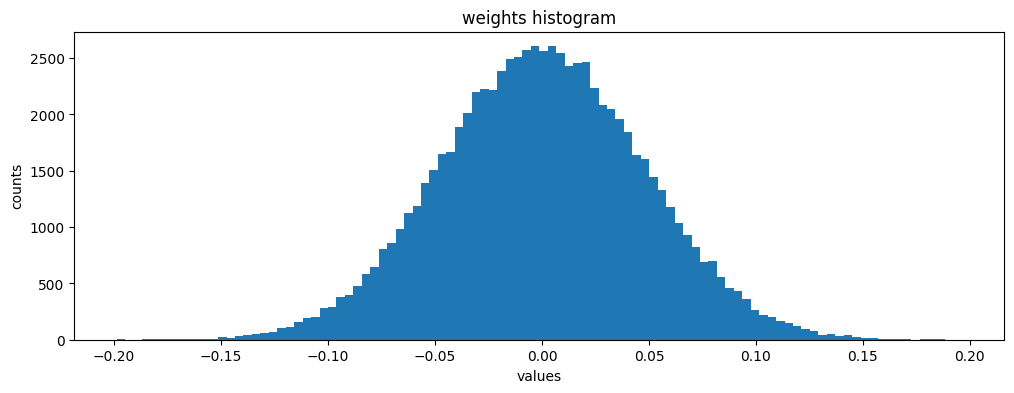

In [ ]:
model_name = "n3_layers_sigmoid_havier"
model = SimpleMNIST_NN(n_layers=3)
model.apply(init_weights)

# plotting weights values of first(input layer)
plt.figure(figsize=(12, 4))
plt.hist(
    list(model.layers.children())[0].weight.cpu().detach().numpy().reshape(-1), bins=100
)
plt.title("weights histogram")
plt.xlabel("values")
plt.ylabel("counts")
plt.show()

In [ ]:
from warnings import simplefilter
from lightning.pytorch.loggers import TensorBoardLogger

simplefilter("ignore", category=RuntimeWarning)


trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SimpleMNIST_NN   | 99.7 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callb

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


# Регуляризация

Второй способ улучшения сходимости нейросетей и борьбы с переобучением — введение регуляризации. Ее можно вводить несколькими способами.

## L1, L2 регуляризации

Cамый простой способ — добавление штрафа к весам в функцию потерь. На сходимость нейросети это, правда, влияет слабо.

$$ \text{Loss_reg} = \text{loss} + \lambda \cdot \text{reg}$$

$$ \text{reg}_{L1} = \lambda \sum |w_i| $$

$$ \text{reg}_{L2} = \lambda \sum w_i^2 $$

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L07/loss_landscape_with_regularization.gif" width="800"></center>

<center><em>Source: <a href="https://people.eecs.berkeley.edu/~jrs/189/">Introduction to Machine Learning
</a></em></center>


Иногда уже этого хватает, чтобы решить все проблемы. Напомним, что **L2** Loss приводит к большому числу маленьких ненулевых весов в сети, а **L1** Loss — к маленькому числу ненулевых весов (разреженной нейросети).

## Dropout

Одним из распространенных именно в нейросетях методом регуляризации является **Dropout**.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/dropout.png" width="700"></center>

Состоит этот метод в следующем:

1. Во время обучения мы с вероятностью $p$ **зануляем выход нейронов** слоя (например, $p = 0.5$).
2. Зануленные нейроны не участвуют в данном `forward`, и поэтому градиент к ним при `backward` не идет.
3. Сила регуляризации определяется вероятностью $p$: чем она больше, тем сильнее регуляризация.

### Мотивация Dropout

#### Борьба с коадаптацией

Одной из  проблем при работе с глубокими сетями является **совместная адаптация нейронов**. Если все весовые коэффициенты обучаются вместе, некоторые соединения будут иметь больше возможностей прогнозирования, чем другие.

**Часть нейронов** делает основную работу — **предсказывает**, а остальные могут вообще не вносить никакого вклада в итоговое предсказание. Или же другая картина: один нейрон делает **неверное предсказание**, другие его **исправляют**, и в итоге первый нейрон свои ошибки не исправляет.

Можно попробовать понять, как это работает, через аналогию — конвейер по сборке машины: основную часть работы может исполнять небольшое количество работников. Другие работники могут лениться и передавать деталь, которая к ним поступила, без изменений или откручивать только что добавленные части. Если мы исключим эффективных работников, результат станет удручающим.

Это явление называется **коадаптацией**. Его нельзя было предотвратить с помощью традиционной регуляризации, такой как **L1** или **L2**. А вот **Dropout** с этим хорошо борется.

Отключая хорошо обученные нейроны, мы заставляем плохо обученные нейроны учиться.

Отключая нейроны, которые исправляют ошибки других нейронов, мы заставляем ошибающиеся нейроны исправлять ошибки.

На изображении ниже из [статьи про Dropout 🎓[article]](https://jmlr.org/papers/v15/srivastava14a.html), сравнение карт признаков для датасета **MNIST**. Слева нейросеть **без Dropout** , справа нейросеть с такой же архитектурой с использованием **Dropout**  ($p = 0.5$).

Слева неструктурированные, беспорядочные паттерны, которые невозможно интерпретировать. Справа явно демонстрируется целенаправленное распределение весов, которое обнаруживает штрихи, края и пятна самостоятельно, нарушая их взаимозависимость с другими нейронами для выполнения этой работы.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L07/compare_weights_with_dropout_and_without_dropout.png" width="600"></center>

<center><em>Source: <a href="https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf">Dropout: A Simple Way to Prevent Neural Networks from
Overfitting</a></em></center>

#### Dropout как регуляризация

Фактически **Dropout** штрафует слишком сложные, неустойчивые решения. Добавляя в нейросеть **Dropout**, мы сообщаем ей, что решение, которое мы ожидаем, должно быть устойчиво к шуму.

#### Dropout как ансамбль

Можно рассматривать **Dropout** как **ансамбль нейросетей** со схожими параметрами, которые мы учим одновременно вместо того, чтобы учить каждую в отдельности, а затем результат их предсказания усредняем, [выключая Dropout в режиме eval ✏️[blog]](https://habr.com/ru/companies/wunderfund/articles/330814/).

Таким образом возникает аналогия со случайным лесом: каждая из наших нейросетей легко выучивает выборку и переобучается — имеет низкий bias, но высокий variance. При этом, за счет временного отключения активаций, каждая нейросеть видит не все объекты, а только часть. Усредняя все эти предсказания, мы уменьшаем variance.

#### Dropout помогает бороться с переобучением

Dropout, в силу указанного выше, может хорошо помогать бороться с переобучением.



<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L07/dropout_solve_overfitting_problem_in_mlp_networks.png" width="500">

<em>Source: <a href="https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/">Tutorial: Dropout as Regularization and Bayesian Approximation</a></em></center>

#### Простая реализация Dropout

Напишем "наивную" реализацию модуля Dropout.

**Замечание:** этот блок кода дан для объяснения работы Dropout. При построении нейронной сети используйте `nn.Dropout` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) или `nn.Dropout2d` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html).

```python
class BadDropout(nn.Module):
    def __init__(self, p: float=0.5):
        super().__init__()
        if p < 0 or p > 1:
            raise ValueError(
                f"Dropout probability has to be between 0 and 1, but got {p}"
            )
        self.p = p

    def forward(self, x):
        if self.training:
            keep = torch.rand(x.size()) > self.p
            if x.is_cuda:
                keep = keep.to(device)
            return x * keep
        # In test time, expectation is calculated
        return x * (1 - self.p)
```



Приведенная реализация неоптимальна, так как в режиме инференса (когда `training = False`) функция `forward` совершает дополнительное умножение. Одним из приоритетов при создании модели является скорость работы в режиме инференса. Поэтому по возможности все "лишние" операции выполняют только в режиме обучения. В данном случае можно целиком убрать коэффициент нормировки из режима инференса, перенеся его в режим обучения в знаменатель.

Дополнительным плюсом такого подхода является то, что при удалении модуля из архитектуры сети функция прогнозирования не изменится.


```python
class Dropout(nn.Module):
    def __init__(self, p: float=0.2):
        super().__init__()
        if p < 0 or p > 1:
            raise ValueError(
                f"Dropout probability has to be between 0 and 1, but got {p}"
            )
        self.p = p

    def forward(self, x):
        if self.training:
            keep = torch.rand(x.size()) > self.p
            if x.is_cuda:
                keep = keep.to(x)
            return x * keep / (1 - self.p)
        return x  # in test time, expectation is calculated intrinsically - we just not divide weights
```



Попробуем применить Dropout в нашей нейросети:

In [ ]:
class SimpleMNIST_NN_Dropout(nn.Module):
    def __init__(self, n_layers, activation=nn.Sigmoid, init_form="normal"):
        super().__init__()
        self.n_layers = n_layers
        self.activation = activation()
        layers = [nn.Linear(28 * 28, 100), self.activation]
        for _ in range(0, n_layers - 1):
            layers.append(nn.Linear(100, 100))
            layers.append(nn.Dropout(p=0.2))  # add Dropout
            layers.append(self.activation)
        layers.append(nn.Linear(100, 10))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.layers(x)
        return x

Так как наша модель из-за Dropout ведет себя по-разному во время обучения и во время тестирования, мы должны прямо ей сообщать, обучается она сейчас или нет.

$$
\begin{array}{c|c}
\large{\text{model.train()}}&\ \large{\text{model.eval()}}\\  \hline
\large{\text{Активируются Dropout слои}}&\large{\text{Слои Dropout отключены}}\\
\large{\text{Выход части нейронов обнуляется, выходы нормируются}}&\large{\text{Все нейроны работают}}
\end{array}
$$



In [ ]:
import torch
from torch import nn

model = nn.Sequential(
    nn.Linear(3072, 500),
    nn.Dropout(p=0.2),
    nn.Linear(500, 1),
    )

model.train()
dummy = torch.randn((1, 3072)) # batch, features
print("Train:")
for i in range(5):
  print(f"\t{model(dummy).item():.4f}")

print("Inference:")
model.eval()
for i in range(5):
  print(f"\t{model(dummy).item():.4f}")


Train:
	0.2007
	-0.1262
	0.0913
	0.2597
	-0.0313
Inference:
	0.2521
	0.2521
	0.2521
	0.2521
	0.2521


Обучим модель с **Dropout**:

In [ ]:
model_name = "nn3_dropout"
model = SimpleMNIST_NN_Dropout(n_layers=3)

trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name, optimizer_kwargs={"lr": 1e-2})

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | SimpleMNIST_NN_Dropout | 99.7 K | train
1 | criterion | CrossEntropyLoss       | 0      | train
-------------------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mod

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


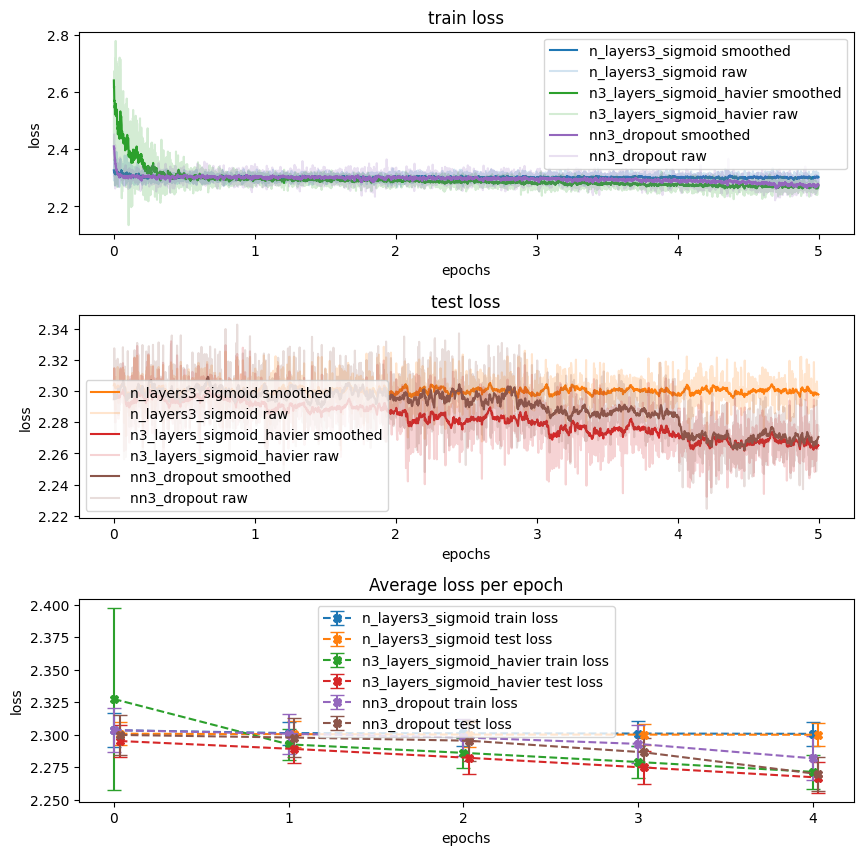

In [ ]:
history_plotter.plot(["n_layers3_sigmoid", "n3_layers_sigmoid_havier", model_name])

В данном случае выигрыш небольшой. Если учить нейросеть больше эпох, эффект будет заметнее.

#### Пример борьбы с переобучением при помощи Dropout


Чтобы увидеть эффект и при этом не учить нейросеть 100+ эпох, сделаем искусственный пример.

Просто **добавим к линейной зависимости шум** и попробуем выучить ее нейронной сетью.

[[colab] 🥨 Batch Normalization and Dropout](https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/7_BatchNormalization/BatchNorm_Dropout.ipynb)

In [ ]:
N = 50  # number of data points
noise = 0.3

# Generate the train data
x_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_train = x_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

# Generate the test data
x_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_test = x_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

print(f"x_train shape: {x_train.shape}\nx_test shape: {x_test.shape}")

x_train shape: torch.Size([50, 1])
x_test shape: torch.Size([50, 1])


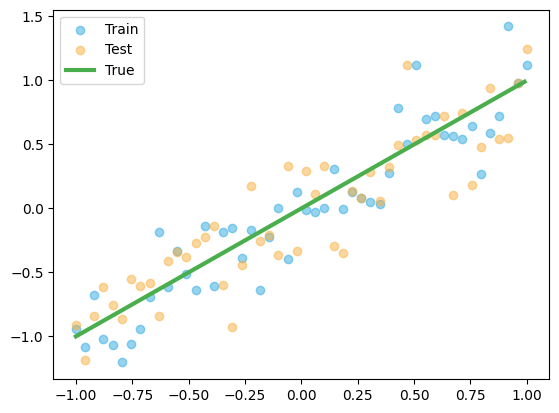

In [ ]:
plt.scatter(
    x_train.data.numpy(), y_train.data.numpy(), c="#2DA9E1", alpha=0.5, label="Train"
)
plt.scatter(
    x_test.data.numpy(), y_test.data.numpy(), c="#F9B041", alpha=0.5, label="Test"
)

x_real = np.arange(-1, 1, 0.01)
y_real = x_real
plt.plot(x_real, y_real, c="#4AAE4D", label="True", linewidth=3)
plt.legend()
plt.show()

Модель **без Dropout**:

In [ ]:
N_h = 100  # num of neurons
model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Модель **с Dropout**:

In [ ]:
N_h = 100  # num of neurons

model_dropout = nn.Sequential(
    nn.Linear(1, N_h),
    nn.Dropout(0.5),  # 50 % probability
    nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    nn.Dropout(0.2),  # 20% probability
    nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)
optimizer_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)

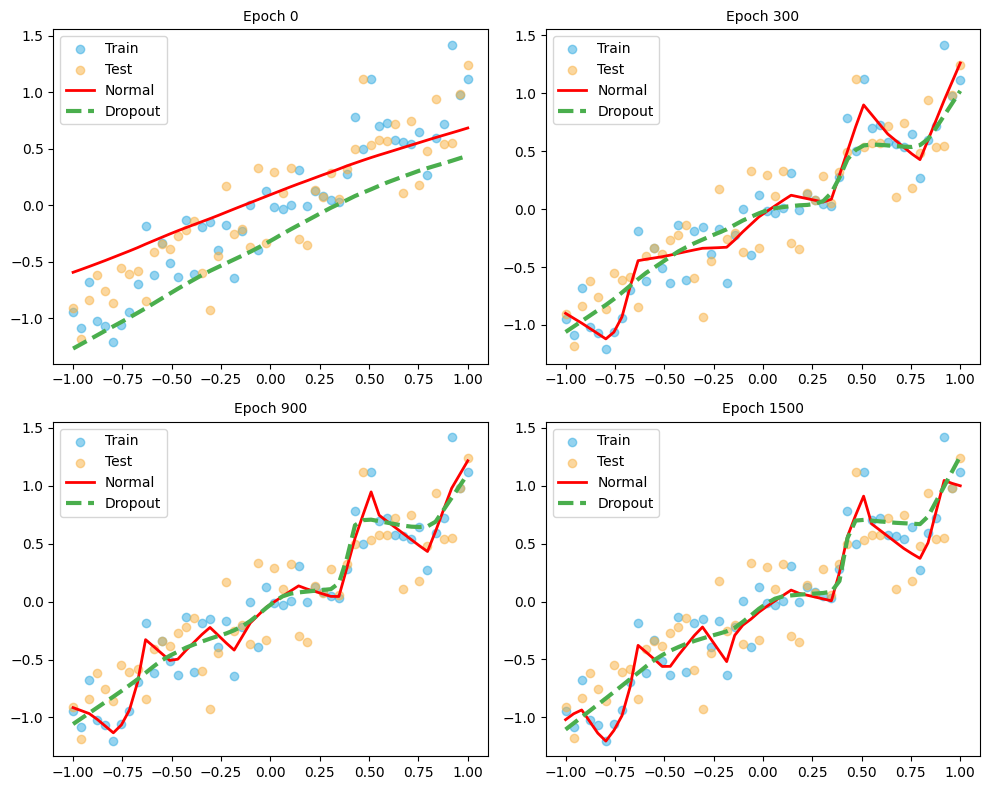

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
plot_epochs = [0, 300, 900, 1500]

num_epochs = 1501
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_dropout = model_dropout(x_train)
    loss_dropout = criterion(y_pred_dropout, y_train)
    optimizer_dropout.zero_grad()
    loss_dropout.backward()
    optimizer_dropout.step()

    if epoch in plot_epochs:
        model.eval()
        model_dropout.eval()

        y_test_pred = model(x_test)
        test_loss = criterion(y_test_pred, y_test)

        y_test_pred_dropout = model_dropout(x_test)
        test_loss_dropout = criterion(y_test_pred_dropout, y_test)

        ax = axes[plot_epochs.index(epoch)]
        ax.scatter(
            x_train.data.numpy(),
            y_train.data.numpy(),
            alpha=0.5,
            c="#2DA9E1",
            label="Train",
        )
        ax.scatter(
            x_test.data.numpy(),
            y_test.data.numpy(),
            c="#F9B041",
            alpha=0.5,
            label="Test",
        )
        ax.plot(
            x_test.data.numpy(), y_test_pred.data.numpy(), "r-", lw=2, label="Normal"
        )
        ax.plot(
            x_test.data.numpy(),
            y_test_pred_dropout.data.numpy(),
            "#4AAE4D", linestyle='dashed',
            lw=3,
            label="Dropout",
        )

        ax.set_title(
            f"Epoch {epoch}",
            fontsize=10,
        )
        ax.legend()
        model.train()
        model_dropout.train()
plt.tight_layout()
plt.show()


Видим, что **нейросеть без Dropout сильно переобучилась**.

#### Доверительный интервал от Dropout

Dropout можно рассматривать как **ансамбль моделей**.

Если мы возьмем один и тот же объект и пропустим его через модель с **активным Dropout 1000 раз**, это будет эквивалентно тому, чтобы пропустить этот объект через **1000 моделей с различными конфигурациями**. Таким образом мы получим распределение предсказаний, на основе которого можно вычислять [**доверительные интервалы** 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%94%D0%BE%D0%B2%D0%B5%D1%80%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D0%B8%D0%BD%D1%82%D0%B5%D1%80%D0%B2%D0%B0%D0%BB) и ловить аномалии (объекты с большой дисперсией предсказываемых значений, которые плохо распознаются сетью).

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L07/confidence_interval_dropout.png" width="600"></center>

<center><em>Source: <a href="https://atcold.github.io/NYU-DLSP20/en/week14/14-3/">Overfitting and regularization</a></em></center>



## DropConnect

Если занулять не нейроны (активации), а случайные веса с вероятностью $p$, получится DropConnect.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/dropconnect.png" width="650"></center>

DropConnect похож на Dropout, поскольку он вводит динамическую разреженность в модель, но отличается тем, что разреженность зависит от весов *W*, а не от выходных векторов слоя. Другими словами, полностью связанный слой с DropConnect становится разреженно связанным слоем, в котором соединения выбираются случайным образом на этапе обучения.

В принципе, вариантов зануления чего-то в нейронной сети можно предложить великое множество, в разных ситуациях будут работать разные способы ([в этом списке 🎓[article]](https://paperswithcode.com/methods/category/regularization) много Drop...).

## DropBlock

Например, можно убирать для каждого батча из нейросети случайные блоки из слоев. И это будет работать!

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/dropblock.png" width="750"></center>

[[arxiv] 🎓 Deep Networks with Stochastic Depth (Huang et al., 2016)](https://arxiv.org/pdf/1603.09382.pdf)

## Советы по использованию Dropout

Наиболее эффективно размещать Dropout для полносвязных (fully connected) слоев, в конце сети.




### Batch Normalization до или после Dropout



#### После

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batchnormalization_after_dropout.png" width="400"></center>

* **Плохо**: В режиме обучения **Dropout** будет отключать (занулять) выходы слоя активации, из-за этого накопленные в режиме обучения **значения скользящего среднего матожидания и дисперсии** для вычисления **Batch Normalization** в режиме тестирования будут иметь **сдвиг** (не компенсируемый приведением слоя Dropout в режим `train()`), который приведет к нестабильной работе нейросети.


Подробно:
* [[arxiv] 🎓 Understanding the Disharmony between Dropout and Batch Normalization by
Variance Shift (Li et al., 2018)](https://arxiv.org/pdf/1801.05134.pdf)
* [[git] 🐾 Understanding the Disharmony between Dropout and Batch Normalization](https://github.com/adelizer/kaggle-sandbox/blob/master/drafts/dropout_bn.ipynb)

#### До

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batchnormalization_before_dropout.png" width="400"></center>

* **Лучше**: Меньше влияние сдвига от **Dropout** на **Batch Norm**. Но если на предыдущих слоях есть **Dropout**, то значения все равно могут быть смещены.

#### Ставить только что-то одно

* **Dropout** может отрицательно влиять на качество нейросети с **Batch Norm** за счет разного поведения на train и test. Поэтому лучше не использовать связку **Dropout** + **Batch Norm** и ставить эти слои в разные части сети. **Batch Norm** после сверточных слоев, **Dropout** в конце сети на полносвязные слои.